In [5]:
import os
from pathlib import Path
from typing import List

from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_qdrant import QdrantVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

/Users/stasstaf/memorix/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def get_embedder():
    # Мультиязычный SOTA-эмбеддер
    model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
    return HuggingFaceEmbeddings(model_name=model_name)


def init_qdrant(collection="lectures", host="http://localhost:6333"):
    client = QdrantClient(url=host)

    if collection not in [c.name for c in client.get_collections().collections]:
        client.create_collection(
            collection_name=collection,
            vectors_config=VectorParams(size=768, distance=Distance.COSINE)
        )
    return client

In [7]:
collection = "lectures"

embedder = get_embedder()
client = init_qdrant(collection)


In [8]:
qdrant = QdrantVectorStore(
    client=client,
    collection_name=collection,
    embedding=embedder,
)


In [9]:
topic = "Определитель матрицы - это"

docs = qdrant.similarity_search(topic, k=10)
for doc in docs:
    print(doc.page_content)
    print(doc.metadata)
    print("-" * 100)

Составим и вычислим определитель матрицы системы:
{'producer': 'Microsoft® Office Word 2007', 'creator': 'Microsoft® Office Word 2007', 'creationdate': 'D:20201014090602', 'author': 'user', 'moddate': 'D:20201014090602', 'source': 'docs/4309_f_41_matematika-1-kurs.pdf', 'total_pages': 180, 'page': 14, 'page_label': '15', '_id': '81984244-71ca-4fd4-b7ee-3b76853e7454', '_collection_name': 'lectures'}
----------------------------------------------------------------------------------------------------
 Матрицы, имеющие одинаковое число строк и число столбцов, а 
также равные соответствующие элементы, называются равными.  Матрица может содержать только один столбец, тогда она 
называется матрицей-столбцом, или только одну строку, тогда она 
называется матрицей-строкой:
 1 3 8 2С  . Вообще говоря, матрица 
может состоять даже из одного элемента. Действия над матрицами 
Над матрицами, как и над числами, можно производить ряд операций, 
причем некоторые из них аналогичны операциям над чи

In [32]:
import json
import os
from pathlib import Path

from openai import OpenAI

MISTRAL_MODEL = "mistral-small-latest"
MISTRAL_API_BASE = "https://api.mistral.ai/v1"


def load_mistral_api_key(env_file: str = ".env") -> str:
    """Грузим ключ из переменных окружения или .env."""
    if os.getenv("MISTRAL_API_KEY"):
        return os.environ["MISTRAL_API_KEY"]

    env_path = Path(env_file)
    if env_path.exists():
        for line in env_path.read_text().splitlines():
            if not line or line.strip().startswith("#"):
                continue
            key, sep, value = line.partition("=")
            if key.strip() == "MISTRAL_API_KEY" and sep:
                os.environ["MISTRAL_API_KEY"] = value.strip().strip('"').strip("'")
                return os.environ["MISTRAL_API_KEY"]

    raise RuntimeError("Укажите MISTRAL_API_KEY в .env или окружении до запуска оценки.")


mistral_client = OpenAI(
    api_key=load_mistral_api_key(),
    base_url=MISTRAL_API_BASE,
)


In [ ]:
from typing import List, Tuple


def call_mistral(messages, **kwargs) -> str:
    request_params = {
        "model": MISTRAL_MODEL,
        "messages": messages,
        "temperature": kwargs.get("temperature", 0.2),
        "max_tokens": kwargs.get("max_tokens", 512),
    }
    resp_format = kwargs.get("response_format")
    if resp_format is not None:
        request_params["response_format"] = resp_format

    response = mistral_client.chat.completions.create(**request_params)
    return response.choices[0].message.content.strip()


def build_context_block(docs: List[Document]) -> str:
    if not docs:
        return "Документы не найдены."

    formatted = []
    for idx, doc in enumerate(docs, 1):
        meta_items = []
        for key, value in (doc.metadata or {}).items():
            if value:
                meta_items.append(f"{key}: {value}")
        meta_info = ", ".join(meta_items) if meta_items else "метаданные отсутствуют"
        formatted.append(f"Источник {idx} ({meta_info}):\n{doc.page_content}")
    return "\n\n".join(formatted)


def generate_rag_answer(question: str, k: int = 5) -> Tuple[str, List[Document]]:
    docs = qdrant.similarity_search(question, k=k)
    context_block = build_context_block(docs)
    user_prompt = f"""
Вопрос студента: {question}

Контекстные фрагменты:
{context_block}

Ответь на вопрос строго по приведенному контексту. Если фактов недостаточно, коротко объясни, что нужной информации нет.
""".strip()
    answer = call_mistral(
        messages=[
            {
                "role": "system",
                "content": "Ты образовательный ассистент. Используй только факты из переданного контекста.",
            },
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.1,
        max_tokens=600,
    )
    return answer, docs


def _parse_json_like(text: str):
    cleaned = text.strip()
    if cleaned.startswith("```") and cleaned.endswith("```"):
        cleaned = cleaned.strip("`")
        if cleaned.startswith("json"):
            cleaned = cleaned[4:]
    if "{" in cleaned and "}" in cleaned:
        start = cleaned.find("{")
        end = cleaned.rfind("}")
        snippet = cleaned[start : end + 1]
        try:
            return json.loads(snippet)
        except json.JSONDecodeError:
            pass
    return None


def evaluate_answer_with_llm(question: str, answer: str, docs: List[Document]):
    context_block = build_context_block(docs)
    judge_prompt = f"""
[Вопрос]
{question}

[Ответ системы]
{answer}

[Контекст]
{context_block}

Оцени, насколько ответ соответствует фактам из контекста. Верни JSON c полями:
- score: число от 1 (плохо) до 5 (отлично)
- verdict: "correct" или "incorrect"
- justification: короткое пояснение
Если контекста недостаточно - оцени низким баллом и напиши почему.
""".strip()

    raw = call_mistral(
        messages=[
            {
                "role": "system",
                "content": "Ты строгий проверяющий качества RAG. Будь честным и ссылайся только на данные контекста.",
            },
            {"role": "user", "content": judge_prompt},
        ],
        temperature=0.0,
        max_tokens=400,
        response_format={"type": "json_object"},
    )

    parsed = _parse_json_like(raw) or {}
    score = parsed.get("score")
    try:
        score = float(score) if score is not None else None
    except (TypeError, ValueError):
        score = None

    return {
        "score": score,
        "verdict": parsed.get("verdict"),
        "justification": parsed.get("justification") or parsed.get("reason") or raw,
        "raw_judgement": raw,
    }


In [36]:
evaluation_dataset = [
    {"question": "Что такое определитель квадратной матрицы и какую информацию он несет?", "topic": "Линейная алгебра"},
    {"question": "Как вычислить определитель верхнетреугольной матрицы?", "topic": "Линейная алгебра"},
    {"question": "Какие условия делают матрицу обратимой?", "topic": "Линейная алгебра"},
    {"question": "Как метод Гаусса используется для решения систем линейных уравнений?", "topic": "Линейная алгебра"},
    {"question": "Что означают собственные значения и векторы матрицы?", "topic": "Линейная алгебра"},
    {"question": "Как диагонализовать симметричную матрицу?", "topic": "Линейная алгебра"},
    {"question": "Чему равна производная суммы функций?", "topic": "Матанализ"},
    {"question": "Как формулируется теорема Ролля?", "topic": "Матанализ"},
    {"question": "В чем смысл правила Лопиталя?", "topic": "Матанализ"},
    {"question": "Как вычисляется производная сложной функции (правило цепочки)?", "topic": "Матанализ"},
    {"question": "Что такое градиент и как он связан с направлением наибольшего роста функции?", "topic": "Матанализ"},
    {"question": "Как определить сходимость числового ряда по признаку сравнения?", "topic": "Матанализ"},
    {"question": "Что такое разложение функции в ряд Тейлора?", "topic": "Матанализ"},
    {"question": "Как найти определенный интеграл методом замены переменной?", "topic": "Матанализ"},
    {"question": "Когда можно применять интегрирование по частям?", "topic": "Матанализ"},
    {"question": "Что описывает уравнение прямой в пространстве и как его получить?", "topic": "Аналитическая геометрия"},
    {"question": "Что такое пространство решений однородной системы?", "topic": "Линейная алгебра"},
    {"question": "Какую геометрическую интерпретацию имеет ядро линейного отображения?", "topic": "Линейная алгебра"},
    {"question": "Что означает положительная определенность квадратичной формы?", "topic": "Линейная алгебра"},
    {"question": "Как вычислить дивергенцию векторного поля?", "topic": "Векторный анализ"},
    {"question": "Что такое кратные интегралы и когда их используют?", "topic": "Матанализ"},
    {"question": "Как сформулировать условие критической точки функции двух переменных?", "topic": "Матанализ"},
    {"question": "Чем отличается неявная функция и как найти её производную?", "topic": "Матанализ"},
    {"question": "Как работает метод Ньютона для поиска корней нелинейных уравнений?", "topic": "Численные методы"},
    {"question": "В чем идея формулы Стокса и что она связывает?", "topic": "Векторный анализ"},
]

print(f"Подготовлено {len(evaluation_dataset)} вопросов для оценки RAG.")


Подготовлено 25 вопросов для оценки RAG.


In [37]:
import time

results = []

for item in evaluation_dataset:
    question = item["question"]
    topic = item["topic"]
    print(f"Вопрос: {question} ({topic})")

    answer, docs = generate_rag_answer(question)
    eval_result = evaluate_answer_with_llm(question, answer, docs)

    eval_result["question"] = question
    eval_result["topic"] = topic
    eval_result["answer"] = answer
    eval_result["retrieved_docs"] = len(docs)
    results.append(eval_result)

    print(f"Ответ RAG: {answer}")
    print(
        f"Оценка LLM: {eval_result.get('score')} (вердикт: {eval_result.get('verdict')})"
    )
    print(f"Комментарий судьи: {eval_result.get('justification')}")
    print("-" * 80)
    time.sleep(0.5)

scored = [r["score"] for r in results if r.get("score") is not None]
if scored:
    avg_score = sum(scored) / len(scored)
    print(f"Средний балл по выборке: {avg_score:.2f}")
else:
    print("Судья не вернул числовые оценки.")

results


Вопрос: Что такое определитель квадратной матрицы и какую информацию он несет? (Линейная алгебра)
Ответ RAG: Определитель квадратной матрицы — это число, характеризующее квадратную матрицу. Он определен только для квадратных матриц и не вычисляется для неквадратных матриц. Определитель матрицы А обозначается как |A|, Δ или det(A).

Для матрицы первого порядка A = [a11], определитель равен a11.

Для матрицы второго порядка
A = [a11 a12; a21 a22], определитель вычисляется по формуле:
|A| = a11 * a22 - a12 * a21.

Определитель несет важную числовую характеристику квадратной матрицы и используется в различных математических операциях, таких как вычисление обратной матрицы, решение систем линейных уравнений и другие.
Оценка LLM: 4.0 (вердикт: correct)
Комментарий судьи: Ответ системы в целом соответствует информации из контекста. Он правильно определяет определитель квадратной матрицы, его обозначения и формулы для матриц первого и второго порядков. Однако, в контексте не указано, что опред

[{'score': 4.0,
  'verdict': 'correct',
  'justification': 'Ответ системы в целом соответствует информации из контекста. Он правильно определяет определитель квадратной матрицы, его обозначения и формулы для матриц первого и второго порядков. Однако, в контексте не указано, что определитель несет важную числовую характеристику квадратной матрицы и используется в различных математических операциях, таких как вычисление обратной матрицы, решение систем линейных уравнений и другие.',
  'raw_judgement': '{\n  "score": 4,\n  "verdict": "correct",\n  "justification": "Ответ системы в целом соответствует информации из контекста. Он правильно определяет определитель квадратной матрицы, его обозначения и формулы для матриц первого и второго порядков. Однако, в контексте не указано, что определитель несет важную числовую характеристику квадратной матрицы и используется в различных математических операциях, таких как вычисление обратной матрицы, решение систем линейных уравнений и другие."\n}',
 

,topic,question,score,verdict,justification
0,Матанализ,Что такое разложение функции в ряд Тейлора?,5.0,correct,Ответ системы соответствует фактам из контекст...
1,Аналитическая геометрия,Что описывает уравнение прямой в пространстве ...,5.0,correct,Ответ системы точно отражает отсутствие информ...
2,Численные методы,Как работает метод Ньютона для поиска корней н...,5.0,correct,"Ответ системы точно отражает информацию, предс..."
3,Линейная алгебра,Как метод Гаусса используется для решения сист...,5.0,correct,"Ответ полностью соответствует информации, пред..."
4,Линейная алгебра,Что означают собственные значения и векторы ма...,5.0,correct,"Ответ системы точно отражает информацию, предс..."
5,Линейная алгебра,Как диагонализовать симметричную матрицу?,5.0,correct,Ответ системы соответствует фактам из контекст...
6,Матанализ,Чему равна производная суммы функций?,5.0,correct,Контекст действительно не содержит информации ...
7,Матанализ,Как формулируется теорема Ролля?,5.0,correct,Контекст не содержит информации о теореме Ролл...
8,Векторный анализ,Как вычислить дивергенцию векторного поля?,5.0,correct,Ответ системы точно отражает отсутствие информ...
9,Матанализ,Что такое градиент и как он связан с направлен...,5.0,correct,Контекст действительно не содержит информации ...


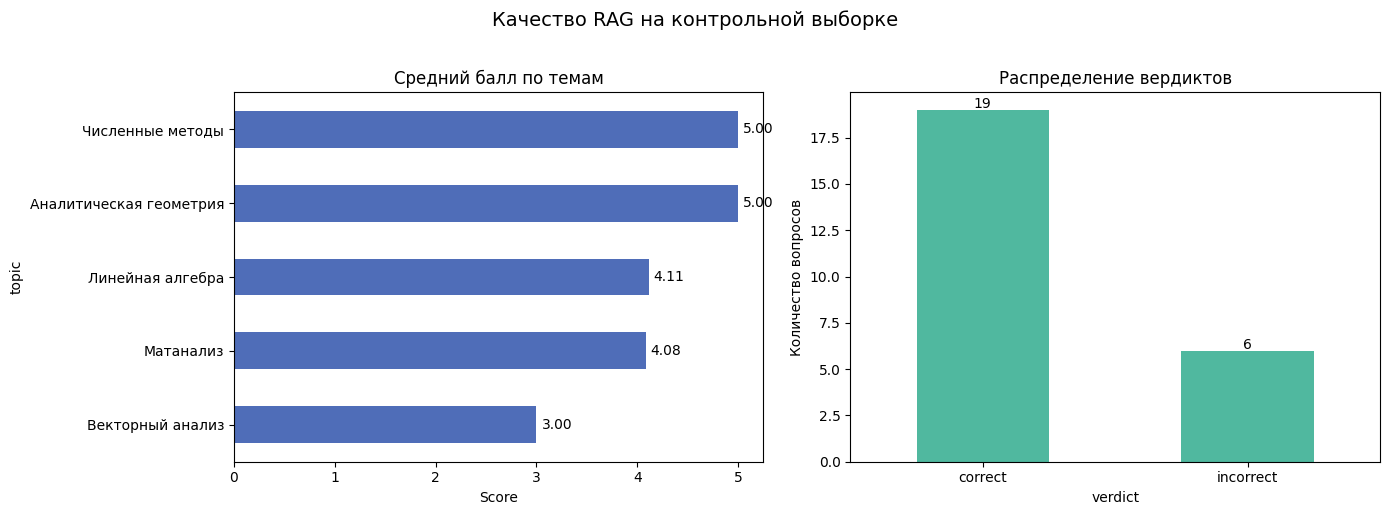

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

if not results:
    print("Нет данных для визуализации. Сначала запустите ячейку с оценкой.")
else:
    df = pd.DataFrame(results)
    df["score"] = pd.to_numeric(df["score"], errors="coerce")
    df["verdict"] = df["verdict"].fillna("unknown")

    display(
        df[["topic", "question", "score", "verdict", "justification"]]
        .sort_values("score", ascending=False)
        .reset_index(drop=True)
    )

    topic_scores = df.groupby("topic")["score"].mean().sort_values()
    verdict_counts = df["verdict"].value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    topic_scores.plot.barh(ax=axes[0], color="#4F6DB8")
    axes[0].set_title("Средний балл по темам")
    axes[0].set_xlabel("Score")
    for idx, value in enumerate(topic_scores):
        axes[0].text(value + 0.05, idx, f"{value:.2f}", va="center")

    verdict_counts.plot.bar(ax=axes[1], color="#50B89F")
    axes[1].set_title("Распределение вердиктов")
    axes[1].set_ylabel("Количество вопросов")
    axes[1].set_xticklabels(verdict_counts.index, rotation=0)
    for idx, value in enumerate(verdict_counts):
        axes[1].text(idx, value + 0.1, int(value), ha="center")

    plt.suptitle("Качество RAG на контрольной выборке", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
